<a id='match processing'></a>
# Match based data processing
* [post-sequence evaluation](#sequence)
    * DIA(Difficulty, implication, amusement) evaluation from note & question
* [match ranking](#match ranking)
    * DIA
* [match statistics processing](#match statistics processing)
    


# Match file

In [1]:
import pandas as pd
import numpy as np
import os
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import matplotlib
import matplotlib.gridspec as gridspec
import scipy.signal as signal

sns.set(color_codes=True)

pd.set_option('display.height', 300)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



# Evaluation

In [13]:
Datapath='./../Dataeva/'
evaluationfile=Datapath+'evaluationn.csv'
dfe=pd.read_csv(evaluationfile,sep=',')
#add sequence label(entrainement-0,match1-1,match2-2,match3-3)+(1°mitemps-1, 2°mitemps-2) 01,02
dfe.ix[dfe['Numéro du Match']=='entrainement',2]=0
dfe.ix[dfe['Quelle mi-temps ?']=='1° Mi-temps',3]=1
dfe.ix[dfe['Quelle mi-temps ?']=='2° Mi-temps',3]=2
dfe['seqlabel']=dfe.apply(lambda row: str(row['Numéro du Match'])+str(row['Quelle mi-temps ?']),axis=1)
#Add Subject label: S2-S58
dfe['sujet']=pd.Series(['S2']*6+map(lambda t: t[0]+str(t[1]), 
    zip(['S']*56*8,[i for i in range(3,59) for _ in range(8)])))

dfe.columns = ['horodateur', 'nom','NoMatch','Nomitemps',
               'noteg','q1','q2','q3','q4','q5','q6','q7','q8',
               'change','emotion','nI','nD','nA','eventchange','quelevent','seqlabel','sujet']
#dfe[dfe.drop(['quelevent','emotion'],axis=1).isnull().any(axis=1)]
dfe

,horodateur,nom,NoMatch,Nomitemps,noteg,q1,q2,q3,q4,q5,q6,q7,q8,change,emotion,nI,nD,nA,eventchange,quelevent,seqlabel,sujet
0,11/05/2016 10:46:02,Rhouzlane Elias,1,1,5,Pas vraiment,Pas vraiment,Un peu,Un peu,Pas vraiment,Plutôt,Pas vraiment,Pas du tout,Peut-être,"Peur, Frustration",3,2,3,Oui,Hors-jeu,11,S2
1,11/05/2016 10:53:34,Rhouzlane Elias,1,2,6,Un peu,Pas vraiment,Plutôt,Plutôt,Un peu,Plutôt,Pas vraiment,Pas du tout,Oui,"Fierté, Frustration",3,2,3,Oui,Action décisive,12,S2
2,11/05/2016 11:20:04,Rhouzlane Elias,2,1,4,Pas vraiment,Pas vraiment,Plutôt,Pas vraiment,Un peu,Plutôt,Pas vraiment,Pas du tout,Non,"Peur, Frustration",3,3,2,Non,NaN,21,S2
3,11/05/2016 11:26:48,Rhouzlane Elias,2,2,4,Pas vraiment,Pas vraiment,Plutôt,Un peu,Plutôt,Plutôt,Pas vraiment,Pas du tout,Oui,"Peur, Colère, Frustration",4,3,3,Oui,But adverse,22,S2
4,11/05/2016 11:53:00,Rhouzlane Elias,3,1,6,Un peu,Pas vraiment,Un peu,Un peu,Pas du tout,Pas vraiment,Plutôt,Pas vraiment,Oui,"Joie, Fierté, Frustration",4,1,3,Oui,"But, lag",31,S2
5,11/05/2016 12:00:06,Rhouzlane Elias,3,2,6,Un peu,Un peu,Plutôt,Un peu,Pas du tout,Plutôt,Pas vraiment,Pas vraiment,Oui,"Joie, Fierté, Frustration",4,1,3,Oui,Tir raté,32,S2
6,12/05/2016 14:04:38,Cairoche Gabrielle,0,1,5,Pas du tout,Pas vraiment,Plutôt,Un peu,Un peu,Beaucoup,Pas du tout,Pas vraiment,Oui,"Fierté, Colère, Frustration",5,3,4,Non,NaN,01,S3
7,12/05/2016 14:05:54,Cairoche Gabrielle,0,2,4,Pas du tout,Pas du tout,Beaucoup,Pas vraiment,Beaucoup,Beaucoup,Pas du tout,Un peu,Oui,"Fierté, Colère, Frustration",5,5,2,Non,NaN,02,S3
8,12/05/2016 14:17:06,Cairoche Gabrielle,1,1,2,Pas du tout,Pas du tout,Beaucoup,Un peu,Plutôt,Beaucoup,Pas du tout,Un peu,Non,"Colère, Frustration",5,5,3,Oui,Le premier but,11,S3
9,12/05/2016 14:24:31,Cairoche Gabrielle,1,2,6,Un peu,Un peu,Beaucoup,Plutôt,Plutôt,Beaucoup,Pas du tout,Pas vraiment,Oui,"Joie, Fierté, Colère, Frustration",5,4,4,Non,NaN,12,S3


In [14]:
def evanote(option):
    return {
        'Pas du tout': 1,
        'Pas vraiment': 2,
        'Un peu':3,
        'Plutôt': 4,
        'Beaucoup': 5,
    }[option]

def qnote(row):
    #amu=(evanote(row['q1'])+evanote(row['q4'])+(6-evanote(row['q8'])))/3.0
    amu=(evanote(row['q1'])+evanote(row['q4']))/2.0
    diffi= ((6-evanote(row['q2']))+evanote(row['q5']))/2.0
    #impli=(evanote(row['q6'])+(6-evanote(row['q7']))+ (6-evanote(row['q8'])))/3.0
    impli=(evanote(row['q6'])+(6-evanote(row['q7'])))/2.0
    return (amu,diffi,impli)
#q1: joyeux
#q2: bon
#q3: frustré
#q4: amusant
#q5: difficile
#q6: concentré
#q7: autre chose
#q8: ennuyé

<a id='sequence'></a>
### Sequence evaluation

In [15]:
dfe['qnote']=dfe.apply (lambda row: qnote(row),axis=1)
dfe['qI']=dfe.apply(lambda row: row['qnote'][2],axis=1)
dfe['qD']=dfe.apply(lambda row: row['qnote'][1],axis=1)
dfe['qA']=dfe.apply(lambda row: row['qnote'][0],axis=1)
dfe.loc[dfe['eventchange']=='Oui','eventchange']=1
dfe.loc[dfe['eventchange']=='Non','eventchange']=0
dfe.loc[dfe['change']=='Oui','change']=1
dfe.loc[dfe['change']=='Non','change']=0
dfe.loc[dfe['change']=='Peut-être','change']=-1
evadf=dfe[['sujet','seqlabel','NoMatch','Nomitemps','noteg','change','eventchange','nI','nD','nA','qI','qD','qA']]
evadf['sujetnum']=evadf.apply(lambda row: int((row['sujet'])[1::]),axis=1)
evadf

/home/wenlu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,sujet,seqlabel,NoMatch,Nomitemps,noteg,change,eventchange,nI,nD,nA,qI,qD,qA,sujetnum
0,S2,11,1,1,5,-1,1,3,2,3,4.0,3.0,2.5,2
1,S2,12,1,2,6,1,1,3,2,3,4.0,3.5,3.5,2
2,S2,21,2,1,4,0,0,3,3,2,4.0,3.5,2.0,2
3,S2,22,2,2,4,1,1,4,3,3,4.0,4.0,2.5,2
4,S2,31,3,1,6,1,1,4,1,3,2.0,2.5,3.0,2
5,S2,32,3,2,6,1,1,4,1,3,4.0,2.0,3.0,2
6,S3,01,0,1,5,1,0,5,3,4,5.0,3.5,2.0,3
7,S3,02,0,2,4,1,0,5,5,2,5.0,5.0,1.5,3
8,S3,11,1,1,2,0,1,5,5,3,5.0,4.5,2.0,3
9,S3,12,1,2,6,1,0,5,4,4,5.0,3.5,3.5,3


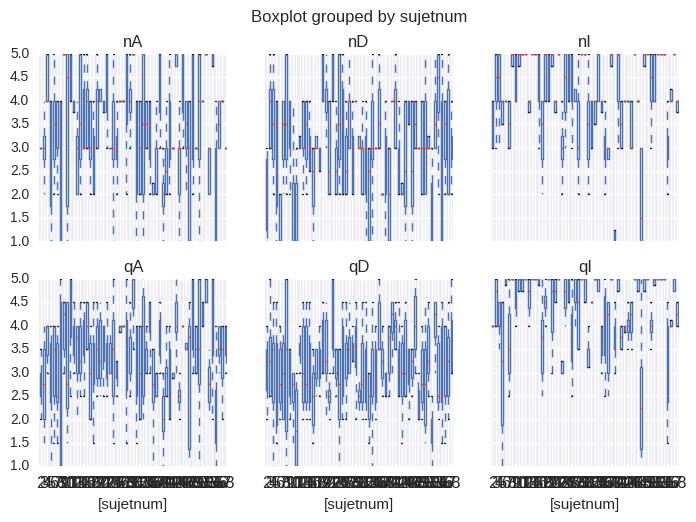

In [5]:
evadf[['sujetnum','nI','nD','nA','qI','qD','qA']].boxplot(by='sujetnum',layout=(2,3))
plt.show()

[back to top](#match processing)

# Evaluation globale

In [6]:
Datapath='./../Dataeva/'
evaluationfile=Datapath+'evaglobal.csv'
dfg1=pd.read_csv(evaluationfile,sep=',')
l=len(dfg1)
dfg1['sujet']=pd.Series(
    map(lambda t: t[0]+str(t[1]),
    zip(['S']*l,range(1,l+1))
       )
    )
dfg1['D']=dfg1['Difficulté'].map(lambda x: x.split('>'))
dfg1['I']=dfg1['Implication'].map(lambda x: x.split('>'))
dfg1['A']=dfg1['Amusement'].map(lambda x: x.split('>'))
dfg1



,Horodateur,Nom/prénom,Difficulté,Implication,Amusement,sujet,D,I,A
0,09/05/2016 14:38:18,Cyrille KAMDEM,1>0>2>3,3>0>2>1,3>0>2>1,S1,"[1, 0, 2, 3]","[3, 0, 2, 1]","[3, 0, 2, 1]"
1,11/05/2016 12:02:11,Rhouzlane Elias,1>0>2>3,2>0>1>3,2>0>3>1,S2,"[1, 0, 2, 3]","[2, 0, 1, 3]","[2, 0, 3, 1]"
2,12/05/2016 15:30:33,Cairoche Gabrielle,1>0>2>3,1>0>3>2,3>1>0>2,S3,"[1, 0, 2, 3]","[1, 0, 3, 2]","[3, 1, 0, 2]"
3,12/05/2016 18:18:19,GOMEZ DAVID,3>1>0>2,3>2>1>0,3>2>1>0,S4,"[3, 1, 0, 2]","[3, 2, 1, 0]","[3, 2, 1, 0]"
4,13/05/2016 12:10:13,RABIA,1>0>3>2,2>3>1>0,3>2>1>0,S5,"[1, 0, 3, 2]","[2, 3, 1, 0]","[3, 2, 1, 0]"
5,13/05/2016 15:34:20,Démétrius/David,1>2>3>0,0>1>2>3,3>2>1>0,S6,"[1, 2, 3, 0]","[0, 1, 2, 3]","[3, 2, 1, 0]"
6,13/05/2016 18:07:01,LE Dao Khanh Vu,2>3>1>0,1>0>3>2,1>0>3>2,S7,"[2, 3, 1, 0]","[1, 0, 3, 2]","[1, 0, 3, 2]"
7,20/05/2016 12:02:43,Dany Naomi,2>0>1>3,0>1>2>3,1>3>2>0,S8,"[2, 0, 1, 3]","[0, 1, 2, 3]","[1, 3, 2, 0]"
8,20/05/2016 15:10:28,kama / babacar,1>2>3>0,1>2>3>0,3>1>2>0,S9,"[1, 2, 3, 0]","[1, 2, 3, 0]","[3, 1, 2, 0]"
9,20/05/2016 17:55:38,Fontaine emile,0>1>2>3,1>2>3>0,2>0>1>3,S10,"[0, 1, 2, 3]","[1, 2, 3, 0]","[2, 0, 1, 3]"


In [7]:
Datapath='./../Dataeva/'
evaluationfile=Datapath+'evaglobal1.csv'
dfg2=pd.read_csv(evaluationfile,sep=',')
l2=len(dfg2)
dfg2['sujet']=pd.Series(
    map(lambda t:t[0]+str(t[1]),zip(['S']*l2,range(18,18+l2)))
)
tmp_diffi=dfg2[['sujet','D0','D1','D2','D3']]
s_diffi=pd.melt(tmp_diffi,id_vars=['sujet']).pivot(index='sujet', columns='value', values='variable').reset_index()
dfg2['D']=s_diffi.apply(lambda row: [int(row[1].split('D')[1]),int(row[2].split('D')[1]),int(row[3].split('D')[1]),int(row[4].split('D')[1])]
              ,axis=1)

tmp_impli=dfg2[['sujet','I0','I1','I2','I3']]
s_impli=pd.melt(tmp_impli,id_vars=['sujet']).pivot(index='sujet', columns='value', values='variable').reset_index()
dfg2['I']=s_impli.apply(lambda row: [int(row[1].split('I')[1]),int(row[2].split('I')[1]),int(row[3].split('I')[1]),int(row[4].split('I')[1])]
              ,axis=1)

tmp_amu=dfg2[['sujet','A0','A1','A2','A3']]
s_amu=pd.melt(tmp_amu,id_vars=['sujet']).pivot(index='sujet', columns='value', values='variable').reset_index()
dfg2['A']=s_amu.apply(lambda row: [int(row[1].split('A')[1]),int(row[2].split('A')[1]),int(row[3].split('A')[1]),int(row[4].split('A')[1])]
              ,axis=1)
tmp_exci=dfg2[['sujet','E0','E1','E2','E3']]
s_exci=pd.melt(tmp_exci,id_vars=['sujet']).pivot(index='sujet', columns='value', values='variable').reset_index()
dfg2['E']=s_exci.apply(lambda row: [int(row[1].split('E')[1]),int(row[2].split('E')[1]),int(row[3].split('E')[1]),int(row[4].split('E')[1])]
              ,axis=1)

<a id='match ranking'></a>
### Match ranking

In [8]:
dfg=dfg1[['sujet','D','I','A']].append(dfg2[['sujet','D','I','A']],ignore_index=True)
dfg['sujetnum']=dfg.apply(lambda row: int((row['sujet'])[1::]),axis=1)
dfg

,sujet,D,I,A,sujetnum
0,S1,"[1, 0, 2, 3]","[3, 0, 2, 1]","[3, 0, 2, 1]",1
1,S2,"[1, 0, 2, 3]","[2, 0, 1, 3]","[2, 0, 3, 1]",2
2,S3,"[1, 0, 2, 3]","[1, 0, 3, 2]","[3, 1, 0, 2]",3
3,S4,"[3, 1, 0, 2]","[3, 2, 1, 0]","[3, 2, 1, 0]",4
4,S5,"[1, 0, 3, 2]","[2, 3, 1, 0]","[3, 2, 1, 0]",5
5,S6,"[1, 2, 3, 0]","[0, 1, 2, 3]","[3, 2, 1, 0]",6
6,S7,"[2, 3, 1, 0]","[1, 0, 3, 2]","[1, 0, 3, 2]",7
7,S8,"[2, 0, 1, 3]","[0, 1, 2, 3]","[1, 3, 2, 0]",8
8,S9,"[1, 2, 3, 0]","[1, 2, 3, 0]","[3, 1, 2, 0]",9
9,S10,"[0, 1, 2, 3]","[1, 2, 3, 0]","[2, 0, 1, 3]",10


[back to top](#match processing)

## Second mi-temps based: physio, nI/D/A, qI/D/A, rankglobal

In [16]:
def rank1(metric):
    dfg['1']=dfg.apply(lambda row: row[metric][0],axis=1)
    dfg['2']=dfg.apply(lambda row: row[metric][1],axis=1)
    dfg['3']=dfg.apply(lambda row: row[metric][2],axis=1)
    dfg['4']=dfg.apply(lambda row: row[metric][3],axis=1)
    return dfg[['sujetnum','1','2','3','4']]

In [17]:
secmi_eva_rank=evadf[(evadf['Nomitemps']==2) & (evadf['sujet']!='S2')]
#Counter(secmi_eva_rank['sujet'])
len(secmi_eva_rank)
rgn=pd.DataFrame({'rgn':(secmi_eva_rank.groupby('sujetnum')['noteg'].rank(ascending=False))})
len(rgn)

224

In [18]:
secmi_eva_rank=evadf[(evadf['Nomitemps']==2) & (evadf['sujet']!='S2')]
rgn=pd.DataFrame({'rgn':(secmi_eva_rank.groupby('sujetnum')['noteg'].rank(ascending=False))})
rnI=pd.DataFrame({'rnI':(secmi_eva_rank.groupby('sujetnum')['nI'].rank(ascending=False))})
rnD=pd.DataFrame({'rnD':(secmi_eva_rank.groupby('sujetnum')['nD'].rank(ascending=False))})
rnA=pd.DataFrame({'rnA':(secmi_eva_rank.groupby('sujetnum')['nA'].rank(ascending=False))})
rqI=pd.DataFrame({'rqI':(secmi_eva_rank.groupby('sujetnum')['qI'].rank(ascending=False))})
rqD=pd.DataFrame({'rqD':(secmi_eva_rank.groupby('sujetnum')['qD'].rank(ascending=False))})
rqA=pd.DataFrame({'rqA':(secmi_eva_rank.groupby('sujetnum')['qA'].rank(ascending=False))})

secmi_eva_rank=secmi_eva_rank.join([rgn,rnI,rnD,rnA,rqI,rqD,rqA])
secmi_eva_rank['NoMatch']=secmi_eva_rank['NoMatch'].astype(str)
secmi_eva_rank['sujetnum']=secmi_eva_rank['sujetnum'].astype(str)
secmi_evarankF=secmi_eva_rank[['sujetnum','NoMatch','Nomitemps','change','eventchange','rgn','rnD','rnI','rnA','rqD','rqI','rqA']]


In [19]:
secmi_evarankF.head()

,sujetnum,NoMatch,Nomitemps,change,eventchange,rgn,rnD,rnI,rnA,rqD,rqI,rqA
7,3,0,2,1,0,3.5,1.0,1.5,3.5,1.0,1.5,4.0
9,3,1,2,1,0,2.0,2.5,1.5,1.0,2.0,1.5,2.0
11,3,2,2,1,1,3.5,2.5,3.5,3.5,3.0,4.0,3.0
13,3,3,2,1,1,1.0,4.0,3.5,2.0,4.0,3.0,1.0
15,4,0,2,-1,1,4.0,3.0,4.0,3.5,3.0,3.5,4.0


### merge sequence based rank with global rank

In [23]:
implicationrank=rank1('I')
difficilerank=rank1('D')
amusantrank=rank1('A')

tmpD=pd.melt(difficilerank,id_vars=['sujetnum'], value_vars=['1','2','3','4']).sort(['sujetnum','value'])
tmpD.columns=['sujetnum','rankgD','NoMatch']
tmpD['NoMatch']=tmpD['NoMatch'].astype(str)
tmpD['sujetnum']=tmpD['sujetnum'].astype(str)

tmpI=pd.melt(implicationrank,id_vars=['sujetnum'], value_vars=['1','2','3','4']).sort(['sujetnum','value'])
tmpI.columns=['sujetnum','rankgI','NoMatch']
tmpI['NoMatch']=tmpI['NoMatch'].astype(str)
tmpI['sujetnum']=tmpI['sujetnum'].astype(str)

tmpA=pd.melt(amusantrank,id_vars=['sujetnum'], value_vars=['1','2','3','4']).sort(['sujetnum','value'])
tmpA.columns=['sujetnum','rankgA','NoMatch']
tmpA['NoMatch']=tmpA['NoMatch'].astype(str)
tmpA['sujetnum']=tmpA['sujetnum'].astype(str)

secmi_evarankF=secmi_evarankF.merge(tmpD, on=['sujetnum','NoMatch'],how='left')
secmi_evarankF=secmi_evarankF.merge(tmpI, on=['sujetnum','NoMatch'],how='left')
secmi_evarankF=secmi_evarankF.merge(tmpA, on=['sujetnum','NoMatch'],how='left')
secmi_evarankF.tail()

,sujetnum,NoMatch,Nomitemps,change,eventchange,rgn,rnD,rnI,rnA,rqD,rqI,rqA,rankgD,rankgI,rankgA
219,57,3,2,1,1,3,3.0,2.0,2.5,2.5,2.0,2,3,2,1
220,58,0,2,0,0,1,4.0,2.5,2.5,3.5,1.5,4,3,4,4
221,58,1,2,0,0,2,2.5,2.5,2.5,3.5,3.5,2,4,3,3
222,58,2,2,0,0,4,2.5,2.5,2.5,2.0,1.5,2,2,2,1
223,58,3,2,1,1,3,1.0,2.5,2.5,1.0,3.5,2,1,1,2


## All mitemps

In [226]:
#allmi_eva_rank=evadf[(evadf['NoMatch']!=0)&(evadf['sujet']!='S2')]
allmi_eva_rank=evadf[(evadf['NoMatch']!=0)]
rgn=pd.DataFrame({'rgn':(allmi_eva_rank.groupby('sujetnum')['noteg'].rank(ascending=False))})
rnI=pd.DataFrame({'rnI':(allmi_eva_rank.groupby('sujetnum')['nI'].rank(ascending=False))})
rnD=pd.DataFrame({'rnD':(allmi_eva_rank.groupby('sujetnum')['nD'].rank(ascending=False))})
rnA=pd.DataFrame({'rnA':(allmi_eva_rank.groupby('sujetnum')['nA'].rank(ascending=False))})
rqI=pd.DataFrame({'rqI':(allmi_eva_rank.groupby('sujetnum')['qI'].rank(ascending=False))})
rqD=pd.DataFrame({'rqD':(allmi_eva_rank.groupby('sujetnum')['qD'].rank(ascending=False))})
rqA=pd.DataFrame({'rqA':(allmi_eva_rank.groupby('sujetnum')['qA'].rank(ascending=False))})

allmi_eva_rank=allmi_eva_rank.join([rgn,rnI,rnD,rnA,rqI,rqD,rqA])
allmi_eva_rank['NoMatch']=allmi_eva_rank['NoMatch'].astype(str)
allmi_eva_rank['sujetnum']=allmi_eva_rank['sujetnum'].astype(str)
allmi_evarankF=allmi_eva_rank[['sujetnum','NoMatch','Nomitemps','change','eventchange','rgn','rnD','rnI','rnA','rqD','rqI','rqA']]
allmi_evarankF.columns = ['sujet', 'match','mitemps','change','eventchange','rgn','rnD','rnI','rnA','rqD','rqI','rqA']
allmi_evarankF=allmi_evarankF.set_index(['sujet', 'match','mitemps'])
allmi_evarankF.to_csv('./../evaRank.csv',encoding='utf-16',index=True)

In [227]:
def rank2class(x):
    if x>3:
        return '1'
    else:
        return '0'
    
allmi_evaclass=allmi_evarankF[['rgn','rnD','rnI','rnA','rqD','rqI','rqA']].applymap(rank2class).join(allmi_evarankF[['change','eventchange']])
allmi_evaclass.to_csv('./../evaClass.csv',encoding='utf-16',index=True)

#### Evaluation of correlation of ranking and auto-evaluation

In [75]:
rankevadfdiff=pd.DataFrame()
rankevadfdiff['rdiffqI']=rankevadf.apply(lambda row: np.fabs(float(row['rankgI'])-float(row['rqI'])),axis=1)
rankevadfdiff['rdiffqD']=rankevadf.apply(lambda row: np.fabs(float(row['rankgD'])-float(row['rqD'])),axis=1)
rankevadfdiff['rdiffqA']=rankevadf.apply(lambda row: np.fabs(float(row['rankgA'])-float(row['rqA'])),axis=1)

rankevadfdiff['rdiffnI']=rankevadf.apply(lambda row: np.fabs(float(row['rankgI'])-float(row['rnI'])),axis=1)
rankevadfdiff['rdiffnD']=rankevadf.apply(lambda row: np.fabs(float(row['rankgD'])-float(row['rnD'])),axis=1)
rankevadfdiff['rdiffnA']=rankevadf.apply(lambda row: np.fabs(float(row['rankgA'])-float(row['rnA'])),axis=1)


In [14]:
rankevadf['sujetNum']=rankevadf.apply(lambda row: int(row['sujet'][1:]),axis=1)
rankevadf.to_csv('./../EvaLabel.csv',encoding='utf-16')

In [15]:
rankevadf.head()

,sujet,seqlabel,NoMatch,Nomitemps,noteg,change,eventchange,noteI,noteD,noteA,qI,qD,qA,rnI,rnD,rnA,rqI,rqD,rqA,rankgI,rankgD,rankgA,rdiffqI,rdiffqD,rdiffqA,rdiffnI,rdiffnD,rdiffnA,sujetNum
0,S3,02,0,2,4,1,0,5,5,2,5.0,5.0,1.5,1.5,1.0,3.5,1.5,1,4,2,2,3,0.5,1,1,0.5,1.0,0.5,3
1,S3,12,1,2,6,1,0,5,4,4,5.0,3.5,3.5,1.5,2.5,1.0,1.5,2,2,1,1,2,0.5,1,0,0.5,1.5,1.0,3
2,S3,22,2,2,4,1,1,4,4,2,4.0,3.0,2.5,3.5,2.5,3.5,4.0,3,3,4,3,4,0.0,0,1,0.5,0.5,0.5,3
3,S3,32,3,2,7,1,1,4,3,3,4.5,2.5,4.0,3.5,4.0,2.0,3.0,4,1,3,4,1,0.0,0,0,0.5,0.0,1.0,3
4,S4,02,0,2,7,-1,1,3,3,4,4.0,2.5,3.0,4.0,3.0,3.5,3.5,3,4,4,3,4,0.5,0,0,0.0,0.0,0.5,4


In [16]:
rankeva=rankevadf.groupby('sujetNum').agg({'rdiffqI':'sum','rdiffqD':'sum','rdiffqA':'sum','rdiffnI':'sum','rdiffnD':'sum','rdiffnA':'sum',})
rankeva.describe()

,rdiffnD,rdiffnA,rdiffnI,rdiffqI,rdiffqA,rdiffqD
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.0000
mean,3.142857,3.589286,3.696429,3.910714,3.517857,3.0000
std,1.843204,1.933220,1.488375,1.719162,1.953934,1.9633
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.0000
25%,2.000000,2.000000,2.750000,2.750000,2.000000,1.0000
50%,3.000000,4.000000,4.000000,4.000000,3.000000,3.0000
75%,4.000000,4.000000,4.000000,5.000000,5.000000,4.0000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.0000


In [73]:
rankeva.sort(['rdiffnD','rdiffnA','rdiffnI']).head()

,rdiffnD,rdiffnA,rdiffnI,rdiffqI,rdiffqA,rdiffqD
sujetNum,,,,,,
38,0,3,2,2,5,2
5,0,6,6,8,5,0
53,1,1,4,4,2,1
55,1,1,4,4,1,3
9,1,2,1,2,1,2


In [18]:
dfg2.head()

,Horodateur,Nom/prénom,I0,I1,I2,I3,D0,D1,D2,D3,A0,A1,A2,A3,E0,E1,E2,E3,sujet,D,I,A,E
0,27/05/2016 15:16:56,Azizi Yacine,1,3,2,4,3,4,1,2,1,3,2,4,2,3,1,4,S18,"[2, 3, 0, 1]","[0, 2, 1, 3]","[0, 2, 1, 3]","[2, 0, 1, 3]"
1,27/05/2016 18:11:31,aznavour alexandre,1,2,3,4,4,3,1,2,3,1,4,2,4,3,1,2,S19,"[2, 3, 1, 0]","[0, 1, 2, 3]","[1, 3, 0, 2]","[2, 3, 1, 0]"
2,30/05/2016 18:25:14,Kissié Christopher,2,1,4,3,4,3,1,2,2,1,4,3,3,2,4,1,S20,"[2, 3, 1, 0]","[1, 0, 3, 2]","[1, 0, 3, 2]","[3, 1, 0, 2]"
3,31/05/2016 15:27:37,Staiano Jacopo,3,2,1,4,2,3,1,4,4,1,2,3,4,1,3,2,S21,"[2, 0, 1, 3]","[2, 1, 0, 3]","[1, 2, 3, 0]","[1, 3, 2, 0]"
4,31/05/2016 17:55:01,SELLE-DELAVAUD Lorraine,2,1,3,4,2,1,3,4,2,1,3,4,2,1,3,4,S22,"[1, 0, 2, 3]","[1, 0, 2, 3]","[1, 0, 2, 3]","[1, 0, 2, 3]"


# Sujet & Match statistics

In [190]:
Datapath='./../Dataeva/'
MatchStafile=Datapath+'MatchSta.csv'
mstadf=pd.read_csv(MatchStafile,sep=',')
niveau={
    'debutant':1,
    'amateur':2,
    'semipro':3,
    'pro':4,
    'champion':5,
    'legend':6
}
mstadf.niveau=mstadf.apply(lambda row: niveau[row['niveau']],axis=1)
mstadf.m1_niveau=mstadf.apply(lambda row: niveau[row['m1_niveau']],axis=1)
mstadf.m2_niveau=mstadf.apply(lambda row: niveau[row['m2_niveau']],axis=1)
mstadf.m3_niveau=mstadf.apply(lambda row: niveau[row['m3_niveau']],axis=1)
mstadf.head()
mstadf.columns


Index([u'sujet', u'niveau', u'm1_niveau', u'm11_score', u'm12_score', u'm2_niveau', u'm21_score', u'm22_score', u'm3_niveau', u'm31_score', u'm32_score', u'but_1', u'tirs_1', u'tirscadre_1', u'possession_1', u'tacles_1', u'fautes_1', u'cartonJaune_1', u'cartonRouge_1', u'blessure_1', u'horsjeu_1', u'corners_1', u'precisiontir_1', u'precisionpasses_1', u'but_2', u'tirs_2', u'tirscadre_2', u'possession_2', u'tacles_2', u'fautes_2', u'cartonJaune_2', u'cartonRouge_2', u'blessure_2', u'horsjeu_2', u'corners_2', u'precisiontir_2', u'precisionpasses_2', u'but_3', u'tirs_3', u'tirscadre_3', u'possession_3', u'tacles_3', u'fautes_3', u'cartonJaune_3', u'cartonRouge_3', u'blessure_3', u'horsjeu_3', u'corners_3', u'precisiontir_3', u'precisionpasses_3'], dtype='object')

In [206]:
mstadf.head()

,sujet,niveau,m1_niveau,m11_score,m12_score,m2_niveau,m21_score,m22_score,m3_niveau,m31_score,m32_score,but_1,tirs_1,tirscadre_1,possession_1,tacles_1,fautes_1,cartonJaune_1,cartonRouge_1,blessure_1,horsjeu_1,corners_1,precisiontir_1,precisionpasses_1,but_2,tirs_2,tirscadre_2,possession_2,tacles_2,fautes_2,cartonJaune_2,cartonRouge_2,blessure_2,horsjeu_2,corners_2,precisiontir_2,precisionpasses_2,but_3,tirs_3,tirscadre_3,possession_3,tacles_3,fautes_3,cartonJaune_3,cartonRouge_3,blessure_3,horsjeu_3,corners_3,precisiontir_3,precisionpasses_3
0,1,1,2,0/1,0/1,1,0/0,0/1,2,0/0,1/0,0/1,1/1,1/1,41/59,0/0,0/1,0/0,0/0,0/0,1/1,1/1,100/100,55/88,0/0,1/3,1/0,41/59,0/4,0/0,0/0,0/0,0/0,0/0,1/1,100/0,73/73,0/0,1/3,1/0,48/52,2/4,0/0,0/0,0/0,0/0,0/0,0/0,100/0,78/74
1,2,4,3,0/0,0/0,5,0/0,0/1,2,1/0,2/0,0/0,1/1,1/0,41/59,2/2,0/0,0/0,0/0,0/0,2/0,0/0,100/0,83/88,0/0,0/3,0/2,41/59,2/1,2/0,1/0,0/0,0/0,0/0,0/2,0/66,70/90,1/0,2/0,2/0,48/52,1/1,0/0,0/0,0/0,0/0,2/0,0/0,100/0,90/85
2,3,2,4,0/3,0/4,2,0/0,0/0,1,0/0,0/0,0/3,0/7,0/3,44/56,0/7,0/0,0/0,0/0,0/0,0/0,0/1,0/42,78/91,0/0,0/3,0/0,53/47,0/2,0/0,0/0,0/0,0/0,0/0,0/2,0/0,84/75,0/0,0/2,0/1,49/51,3/1,0/0,0/0,0/0,0/0,0/0,0/0,0/50,82/70
3,4,3,4,0/0,0/0,2,2/0,4/0,3,0/1,0/1,0/0,2/3,1/3,40/60,1/0,1/0,0/0,0/0,0/0,0/0,1/0,50/100,74/88,2/0,2/0,2/0,53/47,1/1,0/0,0/0,0/0,0/0,1/0,0/0,100/0,87/78,0/1,2/3,2/2,48/52,0/2,0/0,0/0,0/0,0/0,0/1,1/0,100/66,83/83
4,5,5,5,0/0,0/0,4,0/0,1/0,6,0/0,1/0,0/0,0/1,0/0,60/40,1/3,1/1,0/0,0/0,1/0,0/0,0/0,0/0,93/85,0/0,3/1,2/1,62/38,2/3,1/0,1/0,0/0,0/0,1/0,0/0,66/100,95/96,0/0,3/2,1/1,56/44,4/3,1/1,0/0,0/0,0/0,0/0,2/0,33/50,89/91


In [207]:
def stacmp(score):
    if type(score) is str:
        our=int(score.split('/')[0])
        adver=int(score.split('/')[1])
        return (our-adver)/(our+adver+1.0)
    else:
        return np.nan

In [208]:
Matchinfo=mstadf[['sujet','niveau','m1_niveau','m2_niveau','m3_niveau']]
MatchStainfo=mstadf.drop(['sujet','niveau','m1_niveau','m2_niveau','m3_niveau'], axis=1)
MatchStainfo=MatchStainfo.applymap(stacmp)
MatchFeature = pd.concat([Matchinfo,MatchStainfo],axis=1)

MatchFeature.ix[0,2]=3
MatchFeature.ix[10,2]=4
MatchFeature.ix[14,4]=3
MatchFeature.ix[15,2]=3
MatchFeature.ix[19,2]=3
MatchFeature.ix[21,2]=3
MatchFeature.ix[21,4]=2
MatchFeature.ix[22,4]=2
MatchFeature.ix[23,4]=2
MatchFeature.ix[25,4]=5
MatchFeature.ix[35,4]=3
MatchFeature.ix[36,2]=4
MatchFeature.ix[40,2]=1
MatchFeature.ix[41,4]=2

In [209]:
MatchFeature.head()

,sujet,niveau,m1_niveau,m2_niveau,m3_niveau,m11_score,m12_score,m21_score,m22_score,m31_score,m32_score,but_1,tirs_1,tirscadre_1,possession_1,tacles_1,fautes_1,cartonJaune_1,cartonRouge_1,blessure_1,horsjeu_1,corners_1,precisiontir_1,precisionpasses_1,but_2,tirs_2,tirscadre_2,possession_2,tacles_2,fautes_2,cartonJaune_2,cartonRouge_2,blessure_2,horsjeu_2,corners_2,precisiontir_2,precisionpasses_2,but_3,tirs_3,tirscadre_3,possession_3,tacles_3,fautes_3,cartonJaune_3,cartonRouge_3,blessure_3,horsjeu_3,corners_3,precisiontir_3,precisionpasses_3
0,1,1,3,1,2,-0.50,-0.5,0.000000,-0.5,0.0,0.500000,-0.50,0.000000,0.00,-0.178218,0.000,-0.5,0,0,0.0,0.000000,0.0,0.000000,-0.229167,0.000000,-0.400000,0.500000,-0.178218,-0.800000,0.000000,0.0,0,0,0.0,0.000000,0.990099,0.000000,0.0,-0.400000,0.500000,-0.039604,-0.285714,0,0,0,0,0.000000,0.000000,0.990099,0.026144
1,2,4,3,5,2,0.00,0.0,0.000000,-0.5,0.5,0.666667,0.00,0.000000,0.50,-0.178218,0.000,0.0,0,0,0.0,0.666667,0.0,0.990099,-0.029070,0.000000,-0.750000,-0.666667,-0.178218,0.250000,0.666667,0.5,0,0,0.0,-0.666667,-0.985075,-0.124224,0.5,0.666667,0.666667,-0.039604,0.000000,0,0,0,0,0.666667,0.000000,0.990099,0.028409
2,3,2,4,2,1,-0.75,-0.8,0.000000,0.0,0.0,0.000000,-0.75,-0.875000,-0.75,-0.118812,-0.875,0.0,0,0,0.0,0.000000,-0.5,-0.976744,-0.076471,0.000000,-0.750000,0.000000,0.059406,-0.666667,0.000000,0.0,0,0,0.0,-0.666667,0.000000,0.056250,0.0,-0.666667,-0.500000,-0.019802,0.400000,0,0,0,0,0.000000,0.000000,-0.980392,0.078431
3,4,3,4,2,3,0.00,0.0,0.666667,0.8,-0.5,-0.500000,0.00,-0.166667,-0.40,-0.198020,0.500,0.5,0,0,0.0,0.000000,0.5,-0.331126,-0.085890,0.666667,0.666667,0.666667,0.059406,0.000000,0.000000,0.0,0,0,0.5,0.000000,0.990099,0.054217,-0.5,-0.166667,0.000000,-0.039604,-0.666667,0,0,0,0,-0.500000,0.500000,0.203593,0.000000
4,5,5,5,4,6,0.00,0.0,0.000000,0.5,0.0,0.500000,0.00,-0.500000,0.00,0.198020,-0.400,0.0,0,0,0.5,0.000000,0.0,0.000000,0.044693,0.000000,0.400000,0.250000,0.237624,-0.166667,0.500000,0.5,0,0,0.5,0.000000,-0.203593,-0.005208,0.0,0.166667,0.000000,0.118812,0.125000,0,0,0,0,0.000000,0.666667,-0.202381,-0.011050


In [210]:
matlevel=MatchFeature[['m1_niveau','m2_niveau','m3_niveau']]
def rellevelrank (row):
    m1=row['m1_niveau']
    m2=row['m2_niveau']
    m3=row['m3_niveau']
    if m1<m2 & m2<m3:
        a=1;b=2;c=3
    elif m1<m3 & m3<m2:
        a=1;b=3;c=2
    elif m2<m1 & m1<m3:
        a=2;b=1;c=3
    elif m2<m3 & m3<m1:
        a=3;b=1;c=2
    elif m3<m1 & m1<m2:
        a=2;b=3;c=1
    elif m3<m2 & m2<m1:
        a=3;b=2;c=1    
    return (a,b,c)

MatchFeature[['m1_l','m2_l','m3_l']]=matlevel.apply (lambda row: rellevelrank(row),axis=1)
MatchFeature.head()

,sujet,niveau,m1_niveau,m2_niveau,m3_niveau,m11_score,m12_score,m21_score,m22_score,m31_score,m32_score,but_1,tirs_1,tirscadre_1,possession_1,tacles_1,fautes_1,cartonJaune_1,cartonRouge_1,blessure_1,horsjeu_1,corners_1,precisiontir_1,precisionpasses_1,but_2,tirs_2,tirscadre_2,possession_2,tacles_2,fautes_2,cartonJaune_2,cartonRouge_2,blessure_2,horsjeu_2,corners_2,precisiontir_2,precisionpasses_2,but_3,tirs_3,tirscadre_3,possession_3,tacles_3,fautes_3,cartonJaune_3,cartonRouge_3,blessure_3,horsjeu_3,corners_3,precisiontir_3,precisionpasses_3,m1_l,m2_l,m3_l
0,1,1,3,1,2,-0.50,-0.5,0.000000,-0.5,0.0,0.500000,-0.50,0.000000,0.00,-0.178218,0.000,-0.5,0,0,0.0,0.000000,0.0,0.000000,-0.229167,0.000000,-0.400000,0.500000,-0.178218,-0.800000,0.000000,0.0,0,0,0.0,0.000000,0.990099,0.000000,0.0,-0.400000,0.500000,-0.039604,-0.285714,0,0,0,0,0.000000,0.000000,0.990099,0.026144,3,1,2
1,2,4,3,5,2,0.00,0.0,0.000000,-0.5,0.5,0.666667,0.00,0.000000,0.50,-0.178218,0.000,0.0,0,0,0.0,0.666667,0.0,0.990099,-0.029070,0.000000,-0.750000,-0.666667,-0.178218,0.250000,0.666667,0.5,0,0,0.0,-0.666667,-0.985075,-0.124224,0.5,0.666667,0.666667,-0.039604,0.000000,0,0,0,0,0.666667,0.000000,0.990099,0.028409,2,3,1
2,3,2,4,2,1,-0.75,-0.8,0.000000,0.0,0.0,0.000000,-0.75,-0.875000,-0.75,-0.118812,-0.875,0.0,0,0,0.0,0.000000,-0.5,-0.976744,-0.076471,0.000000,-0.750000,0.000000,0.059406,-0.666667,0.000000,0.0,0,0,0.0,-0.666667,0.000000,0.056250,0.0,-0.666667,-0.500000,-0.019802,0.400000,0,0,0,0,0.000000,0.000000,-0.980392,0.078431,3,2,1
3,4,3,4,2,3,0.00,0.0,0.666667,0.8,-0.5,-0.500000,0.00,-0.166667,-0.40,-0.198020,0.500,0.5,0,0,0.0,0.000000,0.5,-0.331126,-0.085890,0.666667,0.666667,0.666667,0.059406,0.000000,0.000000,0.0,0,0,0.5,0.000000,0.990099,0.054217,-0.5,-0.166667,0.000000,-0.039604,-0.666667,0,0,0,0,-0.500000,0.500000,0.203593,0.000000,3,1,2
4,5,5,5,4,6,0.00,0.0,0.000000,0.5,0.0,0.500000,0.00,-0.500000,0.00,0.198020,-0.400,0.0,0,0,0.5,0.000000,0.0,0.000000,0.044693,0.000000,0.400000,0.250000,0.237624,-0.166667,0.500000,0.5,0,0,0.5,0.000000,-0.203593,-0.005208,0.0,0.166667,0.000000,0.118812,0.125000,0,0,0,0,0.000000,0.666667,-0.202381,-0.011050,2,1,3


In [269]:
levelplot=MatchFeature['niveau'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [211]:
def matchSign (row):
    return np.sign([row['m12_score'],row['m22_score'],row['m32_score']])

<a id='match statistics processing'></a>
### Match statistics

In [212]:
matresult=MatchFeature[['sujet','niveau','m1_l','m2_l','m3_l','m12_score','m22_score','m32_score']]
tmp=matresult[['m12_score','m22_score','m32_score']]
matresult[['m1_r','m2_r','m3_r']] =tmp.apply(lambda row: matchSign(row),axis=1)
matresult.head()

,sujet,niveau,m1_l,m2_l,m3_l,m12_score,m22_score,m32_score,m1_r,m2_r,m3_r
0,1,1,3,1,2,-0.5,-0.5,0.500000,-1,-1,1
1,2,4,2,3,1,0.0,-0.5,0.666667,0,-1,1
2,3,2,3,2,1,-0.8,0.0,0.000000,-1,0,0
3,4,3,3,1,2,0.0,0.8,-0.500000,0,1,-1
4,5,5,2,1,3,0.0,0.5,0.500000,0,1,1


In [213]:
def countres(row):
    l=[row['m1_r'],row['m2_r'],row['m3_r']]
    return pd.Series(l).value_counts().sort_index()
tmp=matresult[['m1_r','m2_r','m3_r']]
matresult[['lose','equal','win']]=tmp.apply(lambda row: countres(row),axis=1)
matresult.head()

,sujet,niveau,m1_l,m2_l,m3_l,m12_score,m22_score,m32_score,m1_r,m2_r,m3_r,lose,equal,win
0,1,1,3,1,2,-0.5,-0.5,0.500000,-1,-1,1,2,NaN,1
1,2,4,2,3,1,0.0,-0.5,0.666667,0,-1,1,1,1,1
2,3,2,3,2,1,-0.8,0.0,0.000000,-1,0,0,1,2,NaN
3,4,3,3,1,2,0.0,0.8,-0.500000,0,1,-1,1,1,1
4,5,5,2,1,3,0.0,0.5,0.500000,0,1,1,NaN,1,2


[back to top](#match processing)

In [270]:
matresult.groupby('niveau')[['win','equal','lose']].sum().plot(kind='bar')
plt.show()

In [255]:
tmp1=matresult[['sujet','niveau','m1_l','m2_l','m3_l']]
t1=pd.melt(tmp1, id_vars=['sujet'], value_vars=['m1_l','m2_l','m3_l']).sort('sujet')
t1.columns = ['sujet', 'mat','level']
#t1.reset_index(inplace=True)
tmp2=matresult[['sujet','niveau','m1_r','m2_r','m3_r']]
t2=pd.melt(tmp2, id_vars=['sujet'], value_vars=['m1_r','m2_r','m3_r']).sort('sujet')
t2.columns = ['sujet', 'mat','result']
#t2.reset_index(inplace=True)
t1.head()

,sujet,mat,level
0,1,m1_l,3
58,1,m2_l,1
116,1,m3_l,2
1,2,m1_l,2
59,2,m2_l,3


In [256]:
t1['result']=t2['result']

In [271]:
t1.groupby('level')['result'].agg({'win':lambda x: (x > 0).sum(),'equal':lambda x: (x == 0).sum(),'lose':lambda x: (x < 0).sum()}).plot(kind='bar')
plt.show()

In [262]:
def matstr2num(row):
    if row['mat']=='m1_l':
        a=1
    elif row['mat']=='m2_l':
        a=2
    elif row['mat']=='m3_l':
        a=3
    return a
t1['match']=t1.apply(lambda row: matstr2num(row),axis=1)

In [263]:
t1.head()

,sujet,mat,level,result,matn,match
0,1,m1_l,3,-1,1,1
58,1,m2_l,1,-1,2,2
116,1,m3_l,2,1,3,3
1,2,m1_l,2,0,1,1
59,2,m2_l,3,-1,2,2


In [264]:
t1.groupby('match')['result'].agg({'win':lambda x: (x > 0).sum(),'equal':lambda x: (x == 0).sum(),'lose':lambda x: (x < 0).sum()}).plot(kind='bar')
plt.show()

In [265]:
t1.groupby(['match','level'])['result'].agg({'win':lambda x: (x > 0).sum(),'equal':lambda x: (x == 0).sum(),'lose':lambda x: (x < 0).sum()}).plot(kind='bar')
plt.show()

In [266]:
g = sns.FacetGrid(t1, row="match", col="level")
g.groupby(['match','level'])['result'].agg({'win':lambda x: (x > 0).sum(),'equal':lambda x: (x == 0).sum(),'lose':lambda x: (x < 0).sum()}).plot(kind='bar')

AttributeError: 'FacetGrid' object has no attribute 'groupby'

#### Separate Match

In [247]:
Match1=MatchFeature[['sujet','niveau','m1_niveau','m11_score','m12_score']]
Match1['match']=1
Match1.columns=['sujet','niveausub','niveaumat','butmi1','butmi2','match']

Match2=MatchFeature[['sujet','niveau','m2_niveau','m21_score','m22_score']]
Match2['match']=2
Match2.columns=['sujet','niveausub','niveaumat','butmi1','butmi2','match']

Match3=MatchFeature[['sujet','niveau','m3_niveau','m31_score','m32_score']]
Match3['match']=3
Match3.columns=['sujet','niveausub','niveaumat','butmi1','butmi2','match']

MatchFeatureb=pd.concat([Match1,Match2,Match3],axis=0)
MatchFeatureb.rename(columns={'butmi1':1,'butmi2':2},inplace=True)
# MatchFeatureb=MatchFeatureb.sort(['sujet','match']).reset_index(drop=True)
# MatchFeatureb=MatchFeatureb.set_index(['sujet', 'match'])
MatchFeatureb=pd.melt(MatchFeatureb, id_vars=['sujet','match','niveausub','niveaumat'], value_vars=[1,2],var_name='mitemps', value_name='but').sort(['sujet','match','mitemps']).reset_index(drop=True)
MatchFeatureb=MatchFeatureb.set_index(['sujet','match','mitemps'])
MatchFeatureb.to_csv('./../matbutFeature.csv',encoding='utf-16',index=True)

In [251]:
Match1=MatchFeature[['sujet','niveau','m1_niveau','but_1', 'tirs_1', 'tirscadre_1', 'possession_1', 'tacles_1', 'fautes_1', 'cartonJaune_1', 'cartonRouge_1', 'blessure_1', 'horsjeu_1', 'corners_1', 'precisiontir_1', 'precisionpasses_1']]
Match1['match']=1
Match1['mitemps']=1
Match1.columns=['sujet','niveausub','niveaumat','but', 'tirs', 'tirscadre', 'possession', 'tacles', 'fautes', 'cartonJaune', 'cartonRouge', 'blessure', 'horsjeu', 'corners', 'precisiontir', 'precisionpasses','match','mitemps']

Match2=MatchFeature[['sujet','niveau','m2_niveau','but_2', 'tirs_2', 'tirscadre_2', 'possession_2', 'tacles_2', 'fautes_2', 'cartonJaune_2', 'cartonRouge_2', 'blessure_2', 'horsjeu_2', 'corners_2', 'precisiontir_2', 'precisionpasses_2']]
Match2['match']=2
Match2['mitemps']=1
Match2.columns=['sujet','niveausub','niveaumat','but', 'tirs', 'tirscadre', 'possession', 'tacles', 'fautes', 'cartonJaune', 'cartonRouge', 'blessure', 'horsjeu', 'corners', 'precisiontir', 'precisionpasses','match','mitemps']

Match3=MatchFeature[['sujet','niveau','m3_niveau','but_3', 'tirs_3', 'tirscadre_3', 'possession_3', 'tacles_3', 'fautes_3', 'cartonJaune_3', 'cartonRouge_3', 'blessure_3', 'horsjeu_3', 'corners_3', 'precisiontir_3', 'precisionpasses_3']]
Match3['match']=3
Match3['mitemps']=1
Match3.columns=['sujet','niveausub','niveaumat','but', 'tirs', 'tirscadre', 'possession', 'tacles', 'fautes', 'cartonJaune', 'cartonRouge', 'blessure', 'horsjeu', 'corners', 'precisiontir', 'precisionpasses','match','mitemps']

MatchFeaturest=pd.concat([Match1,Match2,Match3],axis=0)
MatchFeaturest=MatchFeaturest.sort(['sujet','match','mitemps']).reset_index(drop=True)
MatchFeaturest=MatchFeaturest.set_index(['sujet', 'match','mitemps'])
MatchFeaturest.to_csv('./../matstaFeature.csv',encoding='utf-16',index=True)

In [217]:
Match1=MatchFeature[['sujet','niveau','m1_niveau','m11_score','m12_score','but_1', 'tirs_1', 'tirscadre_1', 'possession_1', 'tacles_1', 'fautes_1', 'cartonJaune_1', 'cartonRouge_1', 'blessure_1', 'horsjeu_1', 'corners_1', 'precisiontir_1', 'precisionpasses_1']]
Match1['match']=1
Match1.columns=['sujet','niveausub','niveaumat','butmi1','butmi2','but', 'tirs', 'tirscadre', 'possession', 'tacles', 'fautes', 'cartonJaune', 'cartonRouge', 'blessure', 'horsjeu', 'corners', 'precisiontir', 'precisionpasses','match']

Match2=MatchFeature[['sujet','niveau','m2_niveau','m21_score','m22_score','but_2', 'tirs_2', 'tirscadre_2', 'possession_2', 'tacles_2', 'fautes_2', 'cartonJaune_2', 'cartonRouge_2', 'blessure_2', 'horsjeu_2', 'corners_2', 'precisiontir_2', 'precisionpasses_2']]
Match2['match']=2
Match2.columns=['sujet','niveausub','niveaumat','butmi1','butmi2','but', 'tirs', 'tirscadre', 'possession', 'tacles', 'fautes', 'cartonJaune', 'cartonRouge', 'blessure', 'horsjeu', 'corners', 'precisiontir', 'precisionpasses','match']

Match3=MatchFeature[['sujet','niveau','m3_niveau','m31_score','m32_score','but_3', 'tirs_3', 'tirscadre_3', 'possession_3', 'tacles_3', 'fautes_3', 'cartonJaune_3', 'cartonRouge_3', 'blessure_3', 'horsjeu_3', 'corners_3', 'precisiontir_3', 'precisionpasses_3']]
Match3['match']=3
Match3.columns=['sujet','niveausub','niveaumat','butmi1','butmi2','but', 'tirs', 'tirscadre', 'possession', 'tacles', 'fautes', 'cartonJaune', 'cartonRouge', 'blessure', 'horsjeu', 'corners', 'precisiontir', 'precisionpasses','match']

MatchFeatureS=pd.concat([Match1,Match2,Match3],axis=0)
MatchFeatureS=MatchFeatureS.sort(['sujet','match']).reset_index(drop=True)
MatchFeatureS=MatchFeatureS.set_index(['sujet', 'match'])
MatchFeatureS.head()

niveausub  niveaumat  butmi1  butmi2  but  tirs  tirscadre  possession    tacles    fautes  cartonJaune  cartonRouge  blessure   horsjeu   corners  precisiontir  precisionpasses
sujet match                                                                                                                                                                                   
1     1              1          2    -0.5    -0.5 -0.5  0.00   0.000000   -0.178218  0.000000 -0.500000          0.0            0         0  0.000000  0.000000      0.000000        -0.229167
      2              1          1     0.0    -0.5  0.0 -0.40   0.500000   -0.178218 -0.800000  0.000000          0.0            0         0  0.000000  0.000000      0.990099         0.000000
      3              1          2     0.0     0.5  0.0 -0.40   0.500000   -0.039604 -0.285714  0.000000          0.0            0         0  0.000000  0.000000      0.990099         0.026144
2     1              4          3     0.0     0.0  0.0  0.00   0.500000   -0.178218  0.000000  0.000000          0.0            0         0  0.666667  0.000000      0.990099        -0.029070
      2              4          5     0.0    -0.5  0.0 -0.75  -0.666667   -0.178218  0.250000  0.666667          0.5            0         0  0.000000 -0.666667     -0.985075        -0.124224

In [218]:
MatchFeatureS.to_csv('./../MatchFeature.csv',encoding='utf-16')

# Combine features with evaluation

### Matchfeature

In [211]:
MatchFeatureS=MatchFeatureS.convert_objects(convert_numeric=True)
MatchFeatureS.head()

niveausub  niveaumat  butmi1  butmi2  but  tirs  tirscadre  possession    tacles    fautes  cartonJaune  cartonRouge  blessure   horsjeu   corners  precisiontir  precisionpasses
sujet match                                                                                                                                                                                   
1     1              1          2    -0.5    -0.5 -0.5  0.00   0.000000   -0.178218  0.000000 -0.500000          0.0            0         0  0.000000  0.000000      0.000000        -0.229167
      2              1          1     0.0    -0.5  0.0 -0.40   0.500000   -0.178218 -0.800000  0.000000          0.0            0         0  0.000000  0.000000      0.990099         0.000000
      3              1          2     0.0     0.5  0.0 -0.40   0.500000   -0.039604 -0.285714  0.000000          0.0            0         0  0.000000  0.000000      0.990099         0.026144
2     1              4          3     0.0     0.0  0.0  0.00   0.500000   -0.178218  0.000000  0.000000          0.0            0         0  0.666667  0.000000      0.990099        -0.029070
      2              4          5     0.0    -0.5  0.0 -0.75  -0.666667   -0.178218  0.250000  0.666667          0.5            0         0  0.000000 -0.666667     -0.985075        -0.124224

In [214]:
submatdf=MatchFeatureS[['niveausub','niveaumat']]
submatdf.head()

niveausub  niveaumat
sujet match                      
1     1              1          2
      2              1          1
      3              1          2
2     1              4          3
      2              4          5

### Event feature

In [92]:
def setidxstr(df):
    df=df.reset_index()
    df['sujet']=df['sujet'].astype(str)
    df['match']=df['match'].astype(str)
    df['mitemps']=df['mitemps'].astype(str)
    df=df.set_index(['sujet','match','mitemps'],drop=True)
    return df

In [191]:
EventFeature=pd.read_csv('/home/wenlu/Documents/XPFIFA/EventFeature.csv',encoding='utf-16',index_col=[0,1,2])
EventFeature=EventFeature.fillna(0)
EventFeature=EventFeature.convert_objects(convert_numeric=True)
EventFeature=setidxstr(EventFeature)
EventFeature.head()

all  vapos  vaneg  fortva  arpos  arneg  forar  frus  colere  joie
sujet match mitemps                                                                    
2     1     1          3      1      2       1      3      0      1     1       1     0
            2          6      1      5       2      5      1      1     4       1     0
      2     1         10      1      9       0      9      1      1     4       3     1
            2          7      1      6       1      5      2      1     3       2     0
      3     1         11      2      9       4      9      2      4     6       2     1

In [192]:
allmi_evaclass=setidxstr(allmi_evaclass)
allmi_evaclass.head()

rgn rnD rnI rnA rqD rqI rqA change eventchange
sujet match mitemps                                               
10    1     1         0   1   0   0   1   0   0      1           1
            2         0   1   0   0   1   0   0      1           1
      2     1         1   0   0   1   0   0   1      1           1
            2         0   1   0   0   1   0   0      1           1
      3     1         1   1   1   1   0   1   1      1           1

In [195]:
eventNumData=EventFeature.join(allmi_evaclass, how='inner').reset_index()
eventNumData=eventNumData.convert_objects(convert_numeric=True)

In [193]:
eventNumData=EventFeature.join(allmi_evaclass, how='inner').drop(['level_0','index'],axis=1).reset_index()
eventNumData=eventNumData.convert_objects(convert_numeric=True)

ValueError: labels ['level_0' 'index'] not contained in axis

### Physio feature

In [49]:
PhysioMatFeatureNorm=pd.read_csv('/home/wenlu/Documents/XPFIFA/PhysioMatFeatureNorm.csv',encoding='utf-16',index_col=0)
PhysioWhole=PhysioMatFeatureNorm.ix[(PhysioMatFeatureNorm['Nummitemp']==2)&(PhysioMatFeatureNorm['NumMatch'].isin([1,2,3]))]
PhysioWhole=PhysioWhole.rename(index=str, columns={'NumMatch':'match',})
PhysioWhole=PhysioWhole.drop(['sequence'],axis=1).set_index(['sujet','match','Nummitemp'])
PhysioWhole=PhysioWhole.convert_objects(convert_numeric=True)
PhysioWhole.head()

hbd_mean  hbd_median   hbd_max   hbd_min  hbd_vrange   hbd_var  hbd_std_dev  hbd_avg_der  hbd_max_gra  hbd_abs_dev  hbd_kurtosis  hbd_skewness   hr_mean  hr_median    hr_max    hr_min  hr_vrange    hr_var  hr_std_dev  hr_avg_der  hr_max_gra  hr_abs_dev  hr_kurtosis  hr_skewness     hr_b0     hr_b1     hr_b2     hr_b3     hr_b4    ecg_b0    ecg_b1    ecg_b2    ecg_b3    ecg_b4   emgct_f  emgct_f_s  scramps_mean  scramps_median  scramps_max  scramps_min  scramps_vrange  scramps_var  scramps_std_dev  scramps_avg_der  scramps_max_gra  scramps_abs_dev  scramps_kurtosis  scramps_skewness  eda_ct  eda_mean  eda_median   eda_max   eda_min  eda_vrange   eda_var  eda_std_dev  eda_avg_der  eda_max_gra  eda_abs_dev  eda_kurtosis  eda_skewness    eda_b0    eda_b1    eda_b2    eda_b3    eda_b4  rsprt_mean  rsprt_median  rsprt_max  rsprt_min  rsprt_vrange  rsprt_var  rsprt_std_dev  rsprt_avg_der  rsprt_max_gra  rsprt_abs_dev  rsprt_kurtosis  rsprt_skewness  rsp_mean  \
sujet match Nummitemp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2     1     2         -0.202853   -0.218763 -0.287746 -0.107739   -0.315017 -0.848462    -0.840774     0.705649     0.609294    -0.523872      0.498540      0.692136  0.138159   0.164520 -0.086253  0.408918  -0.672004 -1.176316   -1.281661   -0.399972    0.090898   -0.813330     0.428220    -0.751080 -0.429395 -0.429436  0.619754 -0.614596  0.418535 -0.165309 -0.285102 -0.140330 -0.163467 -0.055566  0.051734  -0.097548           NaN             NaN          NaN          NaN             NaN          NaN              NaN              NaN              NaN              NaN               NaN               NaN     NaN  0.419557    0.487990  0.155325  0.382973   -0.146872 -0.217508    -0.080827     0.219869     0.367100     0.323205     -0.639033     -0.631015 -0.779551 -0.236820 -0.139221 -0.164287 -0.149561    1.060604      0.868891   1.233894   0.748964     -0.533426  -0.577808      -0.511656      -0.450803       1.039043      -0.039731       -0.035107       -0.628365  0.019401   
      2     2          0.186026    0.168116  0.347295  0.267647    0.292991 -0.043301     0.067413     0.442530    -0.241782     0.447733     -0.073249     -0.024249 -0.233399  -0.281782 -0.349881 -0.513767   0.346180 -0.059613    0.017728   -1.030869    0.454743    0.523459    -0.133957     0.234560 -0.595691 -0.595595 -1.083630 -0.604256  0.065590 -0.270572 -0.429405 -0.287028 -0.044264 -0.311899  0.362137   0.292643           NaN             NaN          NaN          NaN             NaN          NaN              NaN              NaN              NaN              NaN               NaN               NaN     NaN -0.587820   -0.770601 -0.303517 -0.721981    0.261128  0.874801     0.993001     0.712130     0.367100     1.713940     -0.753051     -0.276932 -0.427434  1.198224 -0.830356 -1.146302 -1.165548   -1.405054     -1.570122  -1.466873  -0.496121      0.220747   0.005203       0.111133       0.715874       1.118044       0.268947       -0.637711        1.516144  0.617431   
      3     2          1.417388    1.439289  1.736448  

### Evaluation Label

In [28]:
rankevadf.head()

,sujet,seqlabel,NoMatch,Nomitemps,noteg,change,eventchange,noteI,noteD,noteA,qI,qD,qA,rnI,rnD,rnA,rqI,rqD,rqA,rankgI,rankgD,rankgA,rdiffqI,rdiffqD,rdiffqA,rdiffnI,rdiffnD,rdiffnA,sujetNum
0,S3,02,0,2,4,1,0,5,5,2,5.0,5.0,1.5,1.5,1.0,3.5,1.5,1,4,2,2,3,0.5,1,1,0.5,1.0,0.5,3
1,S3,12,1,2,6,1,0,5,4,4,5.0,3.5,3.5,1.5,2.5,1.0,1.5,2,2,1,1,2,0.5,1,0,0.5,1.5,1.0,3
2,S3,22,2,2,4,1,1,4,4,2,4.0,3.0,2.5,3.5,2.5,3.5,4.0,3,3,4,3,4,0.0,0,1,0.5,0.5,0.5,3
3,S3,32,3,2,7,1,1,4,3,3,4.5,2.5,4.0,3.5,4.0,2.0,3.0,4,1,3,4,1,0.0,0,0,0.5,0.0,1.0,3
4,S4,02,0,2,7,-1,1,3,3,4,4.0,2.5,3.0,4.0,3.0,3.5,3.5,3,4,4,3,4,0.5,0,0,0.0,0.0,0.5,4


In [29]:
rankWhole=rankevadf.drop(['sujet','seqlabel','Nomitemps'],axis=1)
rankWhole=rankWhole.ix[rankWhole['NoMatch']!='0',:]
rankWhole['NoMatch']=rankWhole['NoMatch'].astype(int)
rankWhole=rankWhole.rename(index=str,columns={'sujetNum':'sujet','NoMatch':'match'}).set_index(['sujet','match'])
rankWhole=rankWhole.convert_objects(convert_numeric=True)

In [30]:
rankWhole.head()

noteg  change  eventchange  noteI  noteD  noteA   qI   qD   qA  rnI  rnD  rnA  rqI  rqD  rqA  rankgI  rankgD  rankgA  rdiffqI  rdiffqD  rdiffqA  rdiffnI  rdiffnD  rdiffnA
sujet match                                                                                                                                                                            
3     1          6       1            0      5      4      4  5.0  3.5  3.5  1.5  2.5  1.0  1.5    2    2       1       1       2      0.5        1        0      0.5      1.5      1.0
      2          4       1            1      4      4      2  4.0  3.0  2.5  3.5  2.5  3.5  4.0    3    3       4       3       4      0.0        0        1      0.5      0.5      0.5
      3          7       1            1      4      3      3  4.5  2.5  4.0  3.5  4.0  2.0  3.0    4    1       3       4       1      0.0        0        0      0.5      0.0      1.0
4     1          8       1            1      4      5      5  4.0  4.5  4.0  3.0  1.0  1.5  3.5    1    2       3       2       3      0.5        1        1      0.0      1.0      1.5
      2          8      -1            1      5      2      4  4.5  1.0  4.0  1.5  4.0  3.5  1.5    4    2       2       4       2      0.5        0        0      0.5      0.0      1.5

In [31]:
allmerge= rankWhole.join([PhysioWhole,EventFeature,MatchFeatureS])

In [34]:
dataset=allmerge[6::]
#list(dataset.columns.values)
np.array(dataset[['rankgI','rankgD','rankgA']].dropna())


array([[ 1.,  1.,  2.],
       [ 4.,  3.,  4.],
       [ 3.,  4.,  1.],
       [ 3.,  2.,  3.],
       [ 2.,  4.,  2.],
       [ 1.,  1.,  1.],
       [ 3.,  1.,  3.],
       [ 1.,  4.,  2.],
       [ 2.,  3.,  1.],
       [ 2.,  1.,  3.],
       [ 3.,  2.,  2.],
       [ 4.,  3.,  1.],
       [ 1.,  3.,  1.],
       [ 4.,  1.,  4.],
       [ 3.,  2.,  3.],
       [ 2.,  3.,  1.],
       [ 3.,  1.,  3.],
       [ 4.,  4.,  2.],
       [ 1.,  1.,  2.],
       [ 2.,  2.,  3.],
       [ 3.,  3.,  1.],
       [ 1.,  2.,  3.],
       [ 2.,  3.,  1.],
       [ 3.,  4.,  4.],
       [ 1.,  1.,  4.],
       [ 4.,  2.,  3.],
       [ 2.,  3.,  1.],
       [ 2.,  2.,  2.],
       [ 1.,  4.,  1.],
       [ 3.,  3.,  3.],
       [ 2.,  3.,  1.],
       [ 1.,  2.,  2.],
       [ 4.,  1.,  4.],
       [ 2.,  1.,  2.],
       [ 1.,  2.,  1.],
       [ 3.,  4.,  3.],
       [ 2.,  1.,  4.],
       [ 3.,  4.,  1.],
       [ 4.,  2.,  2.],
       [ 2.,  2.,  2.],
       [ 3.,  3.,  1.],
       [ 4.,  1.

In [35]:
datasetv=dataset.drop([ 'scramps_mean',   'scramps_median',   'scramps_max',   'scramps_min',   'scramps_vrange',   'scramps_var',   'scramps_std_dev',   'scramps_avg_der',   'scramps_max_gra',   'scramps_abs_dev',   'scramps_kurtosis',   'scramps_skewness','eda_ct','rsprt_b2','rsprt_b3','rsprt_b4'], axis=1)

In [196]:
datasetv=eventNumData

In [197]:
eventNumData.head()

,sujet,match,mitemps,all,vapos,vaneg,fortva,arpos,arneg,forar,frus,colere,joie,rgn,rnD,rnI,rnA,rqD,rqI,rqA,change,eventchange
0,10,1,1,7,2,5,0,4,3,0,2,3,1,0,1,0,0,1,0,0,1,1
1,10,1,2,6,3,3,1,4,2,2,2,1,2,0,1,0,0,1,0,0,1,1
2,10,2,1,7,2,5,1,5,2,0,3,2,1,1,0,0,1,0,0,1,1,1
3,10,2,2,6,4,2,0,4,2,0,0,1,3,0,1,0,0,1,0,0,1,1
4,10,3,1,8,1,7,0,6,2,1,2,5,1,1,1,1,1,0,1,1,1,1


In [109]:
list(eventNumData.columns.values)

['sujet',
 'match',
 'mitemps',
 u'all',
 u'vapos',
 u'vaneg',
 u'fortva',
 u'arpos',
 u'arneg',
 u'forar',
 u'frus',
 u'colere',
 u'joie',
 'change',
 'eventchange',
 'rgn',
 'rnD',
 'rnI',
 'rnA',
 'rqD',
 'rqI',
 'rqA']

In [204]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn import tree

X=np.array(datasetv.iloc[:,1:13])
Y=np.array(datasetv['rqI']).astype(str)
# clf = RandomForestClassifier(n_estimators=10)
# clf = clf.fit(X, Y)
#clf =tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
clf = svm.SVC(kernel='linear', C=1)
# clf = svm.SVR()
# clf.fit(X, Y) 
scores = cross_validation.cross_val_score(clf, X, Y, cv=5)
scores


array([ 0.61,  0.59,  0.57,  0.65,  0.52])

In [168]:
len(X)

322

In [159]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn import tree

dot_data = StringIO()  
featurename=['match', 'mitemps', 'all', 'vapos', 'vaneg', 'fortva', 'arpos', 'arneg', 'forar', 'frus', 'colere', 'joie']

class_names=['1','0']

from sklearn.externals.six import StringIO
with open("iris.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

In [172]:
from collections import Counter
dict(Counter(Y))

{'-1': 24, '0': 73, '1': 225}

322

In [179]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
X=np.array(datasetv.iloc[:,1:13])
Y=np.array(datasetv['eventchange']).astype(str)
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)
clf = RandomForestClassifier(n_estimators=5)
clf = clf.fit(X, Y)

#y_pred = classifier.fit(X_train, y_train).predict(X_test)
y_pred = clf.predict(X_test)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(dict(Counter(Y)).keys()))
    plt.xticks(tick_marks, dict(Counter(Y)).keys(), rotation=45)
    plt.yticks(tick_marks, dict(Counter(Y)).keys())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[18  7]
 [ 1 55]]
Normalized confusion matrix
[[ 0.72  0.28]
 [ 0.02  0.98]]


In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#listIDA=['noteI','noteD','noteA']
#listIDA=['rankgI','rankgD','rankgA']
#listIDA=['rnI','rnD','rnA']
listIDA=['rqI','rqD','rqA']
data=np.array(dataset[listIDA].dropna())
I=rand_jitter(data[:,0])
D=rand_jitter(data[:,1])
A=rand_jitter(data[:,2])
ax.scatter(I,D,A)
plt.show()